# Optimising the parameters of a simple neuron model

____________
## Introduction

Building biologically-realistic models of neurons requires knowing values for many different parameters. When those are not known or hard to measure experimentally, we can use an optimisation library such as [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) to constrain them with experimental data.


### Overview:
In this tutorial you will learn how to:

* Create a **cell model**
* Extract **electrical features** using eFEL and set up a **cell evaluator**
* Run a **parameter optimization**
* **Analyse** the results of an optimisation


## Load and visualise some electrophysiological data

To model the electrical behaviour of neurons we can use electrophysiological data, recorded during a in vitro [patch clamp experiment](https://en.wikipedia.org/wiki/Patch_clamp). In these types of experiments we inject a current in the neuron and record the voltage response of its membrane.

We are now going to visualise the response of a neuron to a depolarising (positive) current injection and to a hyperpolarising (negative) current.

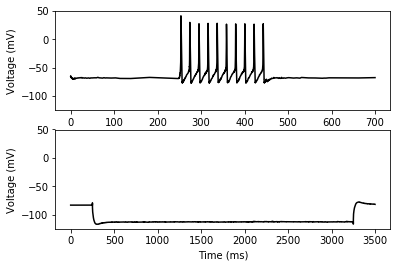

In [1]:
# Download some experimental data and save to file
import urllib2, numpy
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(2, sharey = True)

for i, filename in enumerate({'dep_trace.txt', 'hyp_trace.txt'}):
    response = urllib2.urlopen('https://bbp.epfl.ch/public/MOOC_HBP/{}'.format(filename))
    data = response.read()
    with open(filename, "w") as f:
        f.write(data)
        
    trace = numpy.loadtxt(filename)    
    ax[i].plot(trace[:,0], trace[:,1], color = 'k')
    ax[i].set_ylabel('Voltage (mV)')
    ax[i].set_xlabel('Time (ms)')

We can also create two variables pointing to the experimental recordings for later use. As you can see, each trace is a 2D-array, with the first column representing the time points and the second column the voltage.

In [2]:
exp_pos_trace = numpy.loadtxt("dep_trace.txt")
exp_neg_trace = numpy.loadtxt("hyp_trace.txt")
print(exp_pos_trace)

[[ 0.00000000e+00 -6.50644052e+01]
 [ 3.65780296e-02 -6.45500889e+01]
 [ 7.31560593e-02 -6.58116431e+01]
 ...
 [ 6.62454270e+02 -6.80285806e+01]
 [ 6.85217951e+02 -6.77730746e+01]
 [ 7.00000000e+02 -6.74465859e+01]]


## Define the cell model

In this first part, we will define the model **template**. It consists of:
* The neuron **morphology** (the shape of the cell). It can be farly complicated, but in this example we are approximating it with a single compartment representing the soma of the cell.
* The **ion channel** models (or mechanisms): they contain the equations describing the electrical properties of the cell. 
* The **model parameters**.

BluePyOpt contains a module to create biophysically-detailed neuron models. Let's import it.

In [3]:
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

### Load a morphology

Reconstruction of neuron morphologies can be stored in different file formats ([.swc](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html), .asc). We're now going to load a .swc morphology and visualise it by using the Neuronal Morphology Analysis Tool [NeuroM](https://github.com/BlueBrain/NeuroM). In this example the morphology represents a soma with a radius of 5 micron.

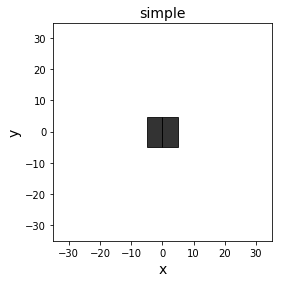

In [4]:
import neurom
import neurom.viewer

# Get the morpholoy file
response = urllib2.urlopen('https://bbp.epfl.ch/public/MOOC_HBP/simple.swc')
data = response.read()

# Save the morphology file   
with open("simple.swc", "w") as f:
    f.write(data)
    
# Visualise the morphology
fig, ax = neurom.viewer.draw(neurom.load_neuron('simple.swc'))

# Load the morphology in BluePyOpt
morph = ephys.morphologies.NrnFileMorphology('simple.swc')


### Add ion channels

In this example we will use the [**Hodgkin-Huxley** (HH) model](https://en.wikipedia.org/wiki/Hodgkin–Huxley_model) to insert sodium (Na), potassium (K) and leak ionic currents in the cell soma. 

We will use the built-in HH mechanism of the [NEURON](https://www.neuron.yale.edu/neuron/) simulator. NEURON can be easily extended with other mechanisms (.mod files) by using the [NMODL](https://www.neuron.yale.edu/neuron/static/new_doc/modelspec/programmatic/mechanisms/nmodl.html) language. In this way we can model other types of ion channels, synapses, extracellular mechanisms... 

To insert a NEURON mechanim into BluePyOpt we need to assign it a **name**, specify the **suffix** pointing to the same field in the .mod file and in which **locations** of the morphology we want to insert it.

In [5]:
# Create a section object pointing to the soma
somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')

# Insert the HH mechanism in the soma
hh_mech = ephys.mechanisms.NrnMODMechanism(                                         
        name='hh',                                                                  
        suffix='hh',                                                                
        locations=[somatic_loc])

### Specify the parameters
We can now specify the parameters of our model. Parameters can be distinguished in two types: **frozen** parameters (i.e. they have an exact value and they are not going to be searched by the optimisation algorithm), **free** parameters (i.e. they have initial bounds for their value and they are going to be searched). 

In a typical biophysically-detailed model the free parameters can be the **maximal conductances** of the ionic currents ($\overline{g}_{ion}$). These parameters are part of the HH equations governing the membrane potential of our neuron soma:

$$C_{m}\frac{dV}{dt} = I_{l} + I_{Na} + I_{K} $$

$$C_{m}\frac{dV}{dt} = \overline{g}_{l}(V-E_{l}) + \overline{g}_{Na}m^{3}h(V-E_{Na}) + \overline{g}_{K}n^{4}(V-E_{K}) $$

We are now going to set the sodium (*gna_par*) and potassium (*gk_par*) conductance as free parameters and the leak conductance (*gl_par*) and the membrane capacitance (*Cm*) as frozen.

In [6]:
# Sodium conductance
gna_par = ephys.parameters.NrnSectionParameter(                                    
        name='gna_soma',
        param_name='gnabar_hh',
        locations=[somatic_loc],
        bounds=[0, 1], # S/cm^2
        frozen=False) 

# Potassium conductance
gk_par = ephys.parameters.NrnSectionParameter(
        name='gk_soma',
        param_name='gkbar_hh',
        bounds=[0, 1], # S/cm^2
        locations=[somatic_loc],
        frozen=False)

# Leak conductance
gl_par = ephys.parameters.NrnSectionParameter(
        name='gl_soma',
        param_name='gl_hh',
        value=0.0003, # S/cm^2
        locations=[somatic_loc],
        frozen=True)

# Membrane capacitance
cm = ephys.parameters.NrnSectionParameter(
        name='cm',
        param_name='cm',
        value=1.0, # in microfarad/cm2
        locations=[somatic_loc],
        frozen=True)

### Create the cell model
We can now create the cell model, by combining the morphology, the mechanisms and the parameters.

In [7]:
simple_cell = ephys.models.CellModel(
        name='simple_cell',
        morph=morph,
        mechs=[hh_mech],
        params=[gna_par, gk_par, gl_par, cm])

We can print a descrition of the neuron.

In [8]:
print(simple_cell)

simple_cell:
  morphology:
    simple.swc
  mechanisms:
    hh: hh at ['somatic']
  params:
    gna_soma: ['somatic'] gnabar_hh = [0, 1]
    gk_soma: ['somatic'] gkbar_hh = [0, 1]
    gl_soma: ['somatic'] gl_hh = 0.0003
    cm: ['somatic'] cm = 1.0



## Set-up a cell evaluator

A cell **evaluator** is an object that maps the model parameters into fitness scores, which measure how well our model approximates the experimental data.
To define a cell evaluator we need:
* current **protocols** to stimulate the cell 
* a **simulation** to record the voltage **response**
* **eFeatures** and **objectives**: they are extracted from the responses and used to score our model, by comparing it with the experimental data.

### Define protocols

Protocols consist of a sequence of stimuli and the associated responses. 

We first need to create a location to inject the stimuli, for example the center of the soma.

In [9]:
soma_loc = ephys.locations.NrnSeclistCompLocation(
        name='soma',
        seclist_name='somatic',
        sec_index=0,
        comp_x=0.5)

Then we can define the stimuli, recordings and combine them in the protocol (a BluePyOpt [SequenceProtocol](https://github.com/BlueBrain/BluePyOpt/blob/master/bluepyopt/ephys/protocols.py#L48) object). We are going to create two stimuli (a negative and a positive current step) and record the responses. For each stimulus we specify the amplitude (in nA), the starting time (step_delay), its duration and the total duration of the simulation in ms. 

In [10]:
sweep_protocols = []

for protocol_name, amp, dur in [('neg_step', -0.01, 3000), ('pos_step', 0.015, 200)]:
    
    stim = ephys.stimuli.NrnSquarePulse(
                step_amplitude=amp,
                step_delay=250,
                step_duration=dur,
                location=soma_loc,
                total_duration=500+dur)
    
    rec = ephys.recordings.CompRecording(
            name='%s.soma.v' % protocol_name,
            location=soma_loc,
            variable='v')
    
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])
    sweep_protocols.append(protocol)

twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

### Running a simulation, record and plot the responses

We can now run a simulation on our cell model. We just need to instantiate the simulator (an abstraction of the NEURON simulator). To run the simulation, we can use the run() function of the protocol we have just created. The run function takes as arguments a cell model, values for the free parameters and a simulator.

In [11]:
# Instantiate the simulator
nrn = ephys.simulators.NrnSimulator()

# Set values for the free parameters (they have to be within bounds)
default_params = {'gna_soma': 0.07, 'gk_soma': 0.03}

# Run the simulation
responses = twostep_protocol.run(cell_model=simple_cell, param_values=default_params, sim=nrn)


We can plot the model responses side by side with the experimental recordings.

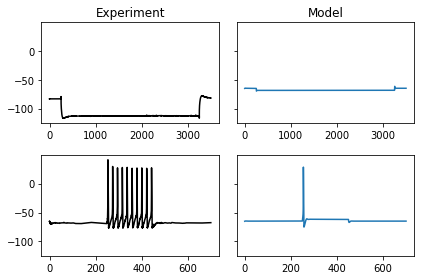

In [12]:
def plot_responses(responses):
    fig1, ax = plt.subplots(len(responses), 2, sharey = True, sharex = 'row')
    
    ax[0,0].plot(exp_neg_trace[:, 0], exp_neg_trace[:,1], color = 'k')            
    ax[0,1].plot(responses['neg_step.soma.v']['time'], responses['neg_step.soma.v']['voltage'])
    ax[0,0].set_title("Experiment")
    ax[0,1].set_title("Model")
    ax[1,0].plot(exp_pos_trace[:, 0], exp_pos_trace[:,1], color = 'k')            
    ax[1,1].plot(responses['pos_step.soma.v']['time'], responses['pos_step.soma.v']['voltage'])

    
    fig1.tight_layout()

plot_responses(responses)

If we change the model parameters, for example big making the sodium conductance bigger, the model behaves differently.

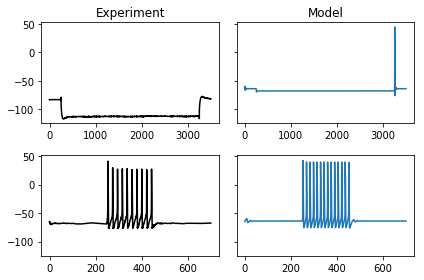

In [13]:
# Set values for the free parameters
default_params = {'gna_soma': 0.15, 'gk_soma': 0.03}

# Run the simulation
responses = twostep_protocol.run(cell_model=simple_cell, param_values=default_params, sim=nrn)

# Run the simulation and plot the responses
plot_responses(responses)

We can observe that after changing the parameters our model starts to approximate the number of spikes in response to the positive current injection, but we also obtained an undesired spike at the end of the negative injection.

### Define eFeatures and objectives

We can now use the experimental data to constrain the model parameters. For example we can use number of spikes in the response to the two steps as the optimisation targets.

We can use the eFeature Extraction Library ([eFEL](https://github.com/BlueBrain/eFEL)) to extract some electrical features (eFeatures) from experimental and model traces. eFeatures are metrics that define for instance the shape of the action potential or the passive properties of a neuron (for examples, see [here](http://bluebrain.github.io/eFEL/eFeatures.html)).

We can now extract the number of spikes from one of the experimental recordings. To extract features with eFEL we need to define the traces we want to analyse as Python dictionaries, containing the time array **T**, the voltage **V**, the **stimulus start** and **end time** (they have to be Python lists) and the **name of the features** we want to extract.

In [14]:
import efel

# Get the time and voltage array from the experimental data
time = exp_pos_trace[:,0]
voltage = exp_pos_trace[:,1]

# Define the trace dictionary for efel
trace = {'T': time, 'V': voltage, 'stim_start': [250], 'stim_end': [450]}

# Extract features
feature_values = efel.getFeatureValues([trace], ['Spikecount'])[0]

print 'Number of spikes in the experimental trace: %s' % feature_values['Spikecount']

Number of spikes in the experimental trace: [10]


We can now use these experimental eFeatures to calculate the fitness of our model. Each eFeature (or a combination of them) can be set as an optimisation target.

In the code below we associate an eFeature to each voltage response and create the eFELFeature and Objective objects.

The eFELFeture ojects takes as arguments the name of the feature in the eFEL, the name of the recordings containg the traces to evaluate, the start and end time of the stimulus and the experimental **feature mean** and **standard deviation** (std). 
In this example we use the feature means extracted from the experimental traces (and stored in the *feat_means* dictionary) and *0.05abs(mean)* as standard deviation.

In [15]:
feat_means = {'neg_step': {'Spikecount': 0}, 'pos_step': {'Spikecount': 10}}

features = []
objectives = []

for protocol in sweep_protocols:   
    stim_start = protocol.stimuli[0].step_delay
    stim_end = stim_start + protocol.stimuli[0].step_duration

    for efel_feature_name, mean in feat_means[protocol.name].items():
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        
        feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names={'': '%s.soma.v' % protocol.name},
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=mean,
                    exp_std=0.05 * abs(mean) if mean != 0 else 1)
        
        features.append(feature)
        objective = ephys.objectives.SingletonObjective(
            feature_name,
            feature)
        objectives.append(objective)


Now that we have defined the objectives, we need to use them to score the model responses by creating a score (or fitness) calculator object.

In [16]:
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives)

We can now define our cell evaluator by combining the cell model, the protocol and the score calculator. We also need to specify a ordered list of the names of the free parameters.

In [17]:
cell_evaluator = ephys.evaluators.CellEvaluator(
        cell_model = simple_cell,
        param_names = ['gna_soma', 'gk_soma'],
        fitness_protocols = {twostep_protocol.name: twostep_protocol},
        fitness_calculator = score_calc,
        sim = nrn)

Now we can ask the evaluator to calculate the scores for a set of parameters. (The lower the score the better the model).
The score for each feature is calculated according to the formula:

$$ score_{feat} = \frac{|mean_{exp}-feat_{model}|}{std_{exp}}$$

We can now the default_params set. From the responses above, we see that there is a spike during the negative stimulus. In response to the positive stimulus, our model fires more than 10 spikes. Thus, none of the two scores will be perfect (= 0).

In [18]:
objectives = cell_evaluator.evaluate_with_dicts(default_params)
print "Scores:"
print objectives

Scores:
{'pos_step.Spikecount': 8.0, 'neg_step.Spikecount': 1.0}


We can also plot scores as error bars.

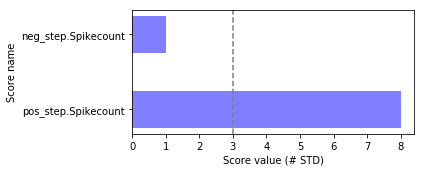

In [19]:
def plot_objectives(objectives):
    ytick_pos = [x + 0.5 for x in range(len(objectives))]
    obj_val = objectives.values()
    obj_keys = objectives.keys()
    fig, ax = plt.subplots(figsize = (6,2.5))
    ax.barh(ytick_pos,
              obj_val,
              height=0.5,
              align='center',
              color='blue',
              alpha=0.5)
    ax.axvline(3, color = "gray", ls = "--")
    ax.set_yticks(ytick_pos)
    ax.set_ylabel("Score name")
    ax.set_xlabel("Score value (# STD)")
    ax.set_yticklabels(obj_keys)
    fig.tight_layout()
plot_objectives(objectives)  

# Set up and run an optimisation

As we have seen above, finding parameter values that match the experimental features may not be trivial.
Let's now use the BluePyOpt parameter optimisation algorithm to find a set of parameter values that generates a perfect score of 0 on the 'pos_step' trace.

BluePyOpt uses an [evolutionary algorithm](https://en.wikipedia.org/wiki/Evolutionary_algorithm) to generate parameter sets (or individual) with increasing fitness. At each iteration (generation) a set of parents from the previous generation is selected to generate an offspring. 

Let us specify that we want to have an offspring size of 15 **individuals**. This means every population will have 30 individuals (15 parents, 15 offspring).

In [20]:
optimisation = bpopt.deapext.optimisations.IBEADEAPOptimisation(                              
        evaluator=cell_evaluator,                                                
        offspring_size = 10)    

Now the optimisation algorithm can be run for a certain **number of generations**.

**Executing the next cell will take some time (a couple of minutes). There will be a ['*'] shown next to line while it is running.**

In [21]:
final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=13)

## Optimisation results

The optimisation has return us 4 objects: final population of parameter sets, hall of fame (the ten best individuals), statistical logs and history.

After running an optimisation, we can inspect the hall of fame and other individuals from the history. In our case it contains values for the parameter *gna_soma* and *gk_soma*.

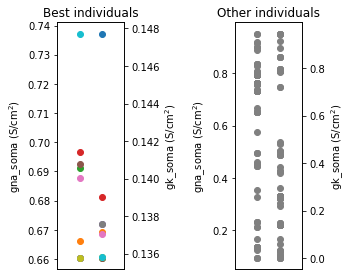

In [22]:
fig, axs = plt.subplots(1,2, figsize = (5,4))
      
ax0 = axs[0].twinx()
ax0.set_ylabel("gk_soma (S/cm$^2$)")
for param_set in hall_of_fame:
    axs[0].plot(0, param_set[0], "o") 
    axs[0].set_ylabel("gna_soma (S/cm$^2$)")
    ax0.plot(1, param_set[1], "o")
    axs[0].set_title("Best individuals")

ax1 = axs[1].twinx()
axs[1].set_ylabel("gna_soma (S/cm$^2$)")
ax1.set_ylabel("gk_soma (S/cm$^2$)")
for param_set in hist.genealogy_history.values()[:100]:
        axs[1].plot(0,param_set[0], "o", color = "gray")
        ax1.plot(1,param_set[1], "o", color = "gray")
        axs[1].set_title("Other individuals")
      
for ax in axs:
    ax.set_xlim([-1,2])
    ax.set_xticks([])
    
    
fig.tight_layout()

The best individual found during the optimisation is the first individual of the hall of fame.

In [23]:
best_ind = hall_of_fame[0]

print 'Best individual: {} '.format(best_ind)

Best individual: [0.6602825410351997, 0.14772567867601205] 


We can make use of a convenience function of the cell evaluator to return us a dictionary of parameters.

In [24]:
best_ind_dict = cell_evaluator.param_dict(best_ind)
print best_ind_dict

{'gk_soma': 0.14772567867601205, 'gna_soma': 0.6602825410351997}


We can now use this dictionary of parameters to run a simulation and give scores to the model, as we did previously.

Score:  {'pos_step.Spikecount': 0.0, 'neg_step.Spikecount': 1.0}


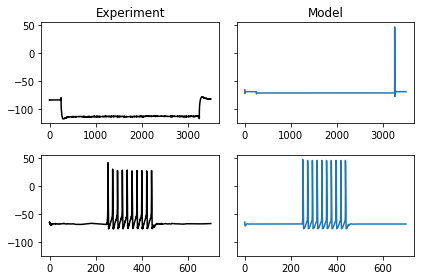

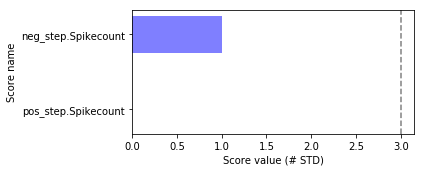

In [25]:
responses = twostep_protocol.run(cell_model=simple_cell, param_values=best_ind_dict, sim=nrn)
plot_responses(responses)

objectives = score_calc.calculate_scores(responses)
print "Score: ", objectives

plot_objectives(objectives)


Let's have a look at the optimisation algorithm statistics. We can plot the minimal score (sum of all the scores) found in every generation.

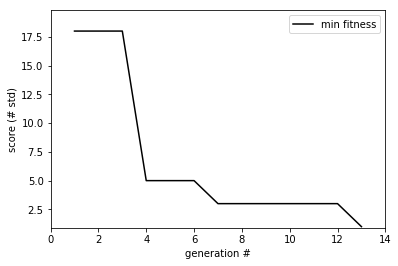

In [26]:
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')

plt.plot(gen_numbers, min_fitness, label='min fitness', color = 'k')
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness));

We can observe a progressive convergence of the model scores towards smaller values. This means that the model features approximating the experimental ones.

## Practise exercises

### Exercise 1: modify the model parameters

* Convert the sodium and potassium conductance from free to frozen parameters and assign them a value of 0.15 and 0.03, respectively
* Convert the leak conductance from frozen to free parameter and assign it bounds of [0, 1e-3]

Below is a copy of some of the above statements. Modify the parameters as described above and run the rest of the code.  Note that we also need to change the cell model, the cell evaluator and the arguments in the run function to make it work with new parameters.

If you completed the exercises successfully, you will obtain a dictionary containg the scores of the model.

In [ ]:
# Sodium conductance
gna_par = ephys.parameters.NrnSectionParameter(                                    
        name='gna_soma',
        param_name='gnabar_hh',
        locations=[somatic_loc],
        bounds=[0, 1], # S/cm^2
        frozen=False) 

# Potassium conductance
gk_par = ephys.parameters.NrnSectionParameter(
        name='gk_soma',
        param_name='gkbar_hh',
        bounds=[0, 1], # S/cm^2
        locations=[somatic_loc],
        frozen=False)

# Leak conductance
gl_par = ephys.parameters.NrnSectionParameter(
        name='gl_soma',
        param_name='gl_hh',
        value=0.0003, # S/cm^2
        locations=[somatic_loc],
        frozen=True)

# Membrane capacitance
cm = ephys.parameters.NrnSectionParameter(
        name='cm',
        param_name='cm',
        value=1.0, # in microfarad/cm2
        locations=[somatic_loc],
        frozen=True)

simple_cell_ex = ephys.models.CellModel(
        name='simple_cell_ex',
        morph=morph,
        mechs=[hh_mech],
        params=[gl_par])

cell_evaluator = ephys.evaluators.CellEvaluator(
        cell_model = simple_cell_ex,
        param_names = ['gl_soma'],
        fitness_protocols = {twostep_protocol.name: twostep_protocol},
        fitness_calculator = score_calc,
        sim = nrn)

ex_params = {'gl_soma': 0.0001}

# Run the simulation
responses = twostep_protocol.run(cell_model=simple_cell_ex, param_values=ex_params, sim=nrn)

print "Scores:"
print cell_evaluator.evaluate_with_dicts(ex_params)

### Exercise 2: extract eFeatures from the experimental recordings

* Extract the features 'sag_amplitude' and 'time_constant' from the experimental trace *exp_neg_trace*.
* Write a *feat_means_ex* dictionary containing the above features for 'neg_step' and 'Spikecount' of 0. For 'pos_step' assign 'Spikecount' of 10 as before.

To help you, we have copied below the statements we used previously. Modify the code to extract the desired features and fill in the *feat_means_ex* dictionary.

Print out the *feature_mean_ex* dictionary.

In [ ]:
import efel

# Get the time and voltage array from the experimental data
time = exp_pos_trace[:,0]
voltage = exp_pos_trace[:,1]

# Define the trace dictionary for efel. Hint: look at one of the traces above to find the correct
# value for 'stim_end'

trace = {'T': time, 'V': voltage, 'stim_start': [250], 'stim_end': [450]}

# Extract features. Hint: change the names to extract the desired features
feature_values_ex = efel.getFeatureValues([trace], ['Spikecount', 'AP_amplitude'])[0]

print 'Sag amplitude value: %s mV' % feature_values_ex['sag_amplitude']
print 'Membrane time constant: %s ms \n' % feature_values_ex['time_constant']

feat_means_ex = {'neg_step': {'Spikecount': 0, 
                              'time_constant': 0,
                              'sag_amplitude': 0}, 'pos_step': {'Spikecount': 0}}

print "Final feat_mean_ex dictionary:"
print feat_means_ex